In [16]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
from scripts.transformer_prediction_interface import TabPFNClassifier

In [17]:
from notebook_utils import *

In [18]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets

In [19]:
from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 149


# Setting params

In [20]:
import os
eval_positions = [1000]
max_features = 100
bptt = 2000
base_path = os.path.join('.')
overwrite = False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
#max_times = [1, 15]
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60]
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [21]:
from scripts.distill_mlp import DistilledTabPFNMLP
from tabpfn.transformer_make_model import PermutationsMeta, ForwardMLPModel
from functools import partial
from scripts.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric


# Baseline Evaluation
This section runs baselines and saves results locally.

In [22]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

/bin/bash: /anaconda/envs/fresh311/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /anaconda/envs/fresh311/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /anaconda/envs/fresh311/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [23]:
cc_valid_datasets_multiclass_df['isNumeric'] = (cc_valid_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_valid_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0) * (cc_valid_datasets_multiclass_df.NumberOfFeatures > 4)
name_indexed_dataset = cc_valid_datasets_multiclass_df.set_index("name")

numeric_valid_datasets = [ds for ds in cc_valid_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
len(numeric_valid_datasets)

54

In [24]:
import os
os.environ["LD_LIBRARY_PATH"] = "/anaconda/envs/fresh311/lib:" + os.environ["LD_LIBRARY_PATH"]

In [25]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
max_times = [1, 5, 15, 60, 5 * 60, 15 * 60, 60* 60]
# these will all be evaluated on CPU because they are given as  callables, which is a weird way to do it.
clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'logistic': logistic_metric,
    'mlp': mlp_metric}

results_baselines = [
    eval_on_datasets('multiclass', model, model_name, numeric_valid_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path)
    for model_name, model in clf_dict.items()
]

evaluating knn on cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating rf_new_params on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1699 out of 1890 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating xgb on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1699 out of 1890 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating logistic on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1699 out of 1890 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating mlp on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1699 out of 1890 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:    2.5s finished


In [55]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from tabpfn.transformer_make_model import ShiftClassifier, EnsembleMeta, ForwardMLPModel

# transformers don't have max times
import warnings
max_times = [1]
device = "cuda:1"

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=32)
#tabpfn_refactor = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=200, N_ensemble_configurations=32)
#tabpfn_refactor_epoch_290 = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=290, N_ensemble_configurations=32)

distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )
distilled_tabpfn_one_layer = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=0, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce2 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=1, learning_rate=0.001, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=2, learning_rate=0.001, model_string=model_string, epoch=82, ))

distilled_tabpfn_two_layer_reproduce_gpu = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))
distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device="cpu", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))



mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(ForwardMLPModel(path=mother_model_string, device=device))
mothernet_new = PermutationsMeta(ForwardMLPModel(path='models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt'))
mothernet_new_again = PermutationsMeta(ForwardMLPModel(path='models_diff/mothernet_from_scratch_again_06_28_2023_20_51_25_epoch_on_exit.cpkt'))

mothernet_big_model_string = "models_diff/prior_diff_real_checkpointwarm_start_depth_18_model_maker_lr0003_multiclass_05_30_2023_22_53_04_n_0_epoch_49.cpkt"
mothernet_big = PermutationsMeta(ForwardMLPModel(path=mothernet_big_model_string, device=device))

model_string_post_refactor = "models_diff/prior_diff_real_checkpointmothernet_from_scratch_lr0003_warm_start_continue2_multiclass_05_31_2023_19_21_34_n_0_epoch_94.cpkt"
mothernet_post_refactor = PermutationsMeta(ForwardMLPModel(path=model_string_post_refactor, device=device))

model_string_mothernet_small_batches = "models_diff/mothernet_512_everywhere_steps_1024_batch_16_07_02_2023_17_29_55_epoch_on_exit.cpkt"
mothernet_small_batches = PermutationsMeta(ForwardMLPModel(path=model_string_mothernet_small_batches, device=device))


model_string_old_reference_config = "reproduce_reference_config_06_02_2023_17_08_59"
old_reference_config = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch="on_exit", N_ensemble_configurations=32)
old_reference_config_epoch_290 = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch=290, N_ensemble_configurations=32)

model_string_reference_config_continue =  "reproduce_reference_config_continue_06_05_2023_17_45_06"
reference_config_continue = TabPFNClassifier(device=device, model_string=model_string_reference_config_continue, epoch="on_exit", N_ensemble_configurations=32)



model_string_reference_config_long = "reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10"
reference_config_long = TabPFNClassifier(device=device, model_string=model_string_reference_config_long, epoch="on_exit", N_ensemble_configurations=32)

perceiver_long = ForwardMLPModel(path="models_diff/perceiver_output_128_emsize_512_nlayers_12_steps_1024_07_01_2023_17_56_04_epoch_690.cpkt", device=device)
perceiver_long_permutations = PermutationsMeta(perceiver_long)

model_string_newest_mlflow = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1350.cpkt"
mothernet_mlflow_04_54_38 = PermutationsMeta(ForwardMLPModel(path=model_string_newest_mlflow, device=device))

model_string_newest_mlflow_1750 = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1750.cpkt"
mothernet_mlflow_04_54_38_e1750 = PermutationsMeta(ForwardMLPModel(path=model_string_newest_mlflow_1750, device=device))
mothernet_mlflow_04_54_38_e1750_ensemble = EnsembleMeta(ForwardMLPModel(path=model_string_newest_mlflow_1750, device=device))


#mothernet_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1350", N_ensemble_configurations=32)

mothernet_new_old_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0", epoch="on_exit", N_ensemble_configurations=32)
mothernet_new_old_ensemble =  EnsembleMeta(ForwardMLPModel(device=device, path="models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt"), n_estimators=32)

#mothernet_1750_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1750", N_ensemble_configurations=32)


perceiver_16_19_18_ensemble =  EnsembleMeta(ForwardMLPModel(device=device, path="models_diff/perceiver_128_emsize_512_nlayers_12_steps_4096_batch_64_lr_3e-05_one_gpu_07_11_2023_16_19_18_epoch_1120.cpkt"), n_estimators=32)

mlflow_validate_str = "tabpfn_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_8ada_lr_3e-05_1_gpu_07_21_2023_21_58_32"
mlflow_validate_tabpfn = TabPFNClassifier(device=device, model_string=mlflow_validate_str, epoch="1470", N_ensemble_configurations=32)

#mother_of_ensembles = BaggingClassifier(PermutationsMeta(ForwardMLPModel(path=mother_model_string)), max_features=.8, max_samples=.8)
#mother_of_ensembles_again = BaggingClassifier(PermutationsMeta(ForwardMLPModel(path=mother_model_string)), max_features=.5, max_samples=.5)
forward_mlp_scaled = make_pipeline(StandardScaler(), forward_mlp)
distilled_tabpfn_scaled = make_pipeline(StandardScaler(), distilled_tabpfn)


new_tabpfn_long_e1020 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1020", N_ensemble_configurations=32)
# large batchsize large learning rate
mothernet_old_config_repro_20_10_21_ensemble = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_512_bs_8192_lr_0.0003_1_gpu_07_28_2023_20_10_21_epoch_2000.cpkt", device=device))
# small batchsize small learning rate
mothernet_new_config_04_14_37_ensemble_e1390 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1390.cpkt", device=device)) 
mothernet_new_config_04_14_37_ensemble_e1520 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1520.cpkt", device=device)) 

mothernet_01_07_16_e1560 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1560.cpkt", device=device))
mothernet_21_29_51_e5610 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_E8000_1_gpu_08_01_2023_21_29_51_epoch_5610.cpkt", device=device))

low_rank_48_19 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_L2_W128_P512_1_gpu_08_03_2023_03_48_19_epoch_on_exit.cpkt", device=device))
mothernet_L2_18_33_e780 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_31_2023_23_18_33_epoch_780.cpkt", device=device))

mothernet_15_46_11_e120 =  EnsembleMeta(ForwardMLPModel(path="models_diff/mn_d1024_H2048_l1e-06_b32_noprenormTrue_1_gpu_warm_08_13_2023_15_46_11_epoch_130.cpkt", device=device))
tabpfn_21_43_17_e760 =  TabPFNClassifier(model_string="tabpfn_n512_l1e-05_b32_mtabpfn_noprenormTrue_1_gpu_warm_08_11_2023_21_43_17", device=device, epoch=760, N_ensemble_configurations=32)
mothernet_01_07_16_e1720 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu_ensemble3 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device), n_estimators=3)
mothernet_01_07_16_e1720_cpu_ensemble3 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device="cpu"), n_estimators=3)
mothernet_05_25_46_e5900 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_5900.cpkt", device=device))

# actually accidentally trained with false due to bug, even if config says true
reference_config_long.model.efficient_eval_masking = False
clf_dict= {
    
     #        'transformer': transformer_metric,
            'transformer_gpu_timing': TabPFNClassifier(device=device, N_ensemble_configurations=3),

       #          'transformer_recompute': transformer_metric,
              # 'tabpfn_mine': partial(transformer_metric, classifier=tabpfn_mine),
             #  'tabpfn_post_mlflow': partial(transformer_metric, classifier=mlflow_validate_tabpfn),
              # 'tabpfn_mine_post_get_model_refactor': partial(transformer_metric, classifier=tabpfn_mine),
    #'distill_tabpfn_scaled':  partial(transformer_metric, classifier=distilled_tabpfn_scaled),
###    'distill_tabpfn_one_layer': partial(transformer_metric, classifier=distilled_tabpfn_one_layer),
###        'distill_tabpfn_one_layer_512_no_dropout': partial(transformer_metric, classifier=distilled_tabpfn_one_layer_512_no_dropout),

###        'distill_tabpfn_two_layer_512_no_dropout': partial(transformer_metric, classifier=distilled_tabpfn_two_layer_512_no_dropout),

#    'distill_tabpfn_one_layer_no_dropout': partial(transformer_metric, classifier=distilled_tabpfn_one_layer_no_dropout),

       #         'mother_of_ensembles': partial(transformer_metric, classifier=mother_of_ensembles),
       #         'mother_of_ensembles_again': partial(transformer_metric, classifier=mother_of_ensembles_again),

     #          'mother_net': partial(transformer_metric, classifier=forward_mlp),
     #           'mothernet_new': partial(transformer_metric, classifier=mothernet_new),
                #'mothernet_big': partial(transformer_metric, classifier=mothernet_big),
                #'mothernet_post_refactor': partial(transformer_metric, classifier=mothernet_post_refactor),
       #         'mothernet_new_again': partial(transformer_metric, classifier=mothernet_new_again),
       #             'mothernet_small_batches': partial(transformer_metric, classifier=mothernet_small_batches),
      #          'perceiver_long': partial(transformer_metric, classifier=perceiver_long),
    #'perceiver_long_permutations': partial(transformer_metric, classifier=perceiver_long_permutations),
    #'mothernet_mlflow_04_54_38': partial(transformer_metric, classifier=mothernet_mlflow_04_54_38),
    #'mothernet_mlflow_04_54_38_e1750':  partial(transformer_metric, classifier=mothernet_mlflow_04_54_38_e1750),
    #'mothernet_tabpfn_preprocessing': partial(transformer_metric, classifier=mothernet_tabpfn_preprocessing),
    #'mothernet_new_old_tabpfn_preprocessing': partial(transformer_metric, classifier=mothernet_new_old_tabpfn_preprocessing),
    #'mothernet_mlflow_04_54_38_e1750_ensemble':  partial(transformer_metric, classifier=mothernet_mlflow_04_54_38_e1750_ensemble),
     #   'mothernet_1750_tabpfn_preprocessing':  partial(transformer_metric, classifier=mothernet_1750_tabpfn_preprocessing),
    #'mothernet_new_old_ensemble': partial(transformer_metric, classifier=mothernet_new_old_ensemble),
#        'new_tabpfn_long_e1020': partial(transformer_metric, classifier=new_tabpfn_long_e1020),
        
    # doing it again cause weird bug in the inference code
       # 'mothernet_old_config_repro_20_10_21_ensemble_again': partial(transformer_metric, classifier=mothernet_old_config_repro_20_10_21_ensemble),
       # 'mothernet_new_config_04_14_37_ensemble_e1390_again': partial(transformer_metric, classifier=mothernet_new_config_04_14_37_ensemble_e1390),
       #     'mothernet_new_config_04_14_37_ensemble_e1520': partial(transformer_metric, classifier=mothernet_new_config_04_14_37_ensemble_e1520),

       # 'mothernet_21_29_51_e5610_again': partial(transformer_metric, classifier=mothernet_21_29_51_e5610),
       # 'mothernet_low_rank_48_19': partial(transformer_metric, classifier=low_rank_48_19),
      #  'mothernet_L2_18_33_e780': partial(transformer_metric, classifier=mothernet_L2_18_33_e780),
      #  'mothernet_01_07_16_e1560': partial(transformer_metric, classifier=mothernet_01_07_16_e1560),
      #  'mothernet_15_46_11_e120': partial(transformer_metric, classifier=mothernet_15_46_11_e120),
#        'tabpfn_21_43_17_e760': partial(transformer_metric, classifier=tabpfn_21_43_17_e760),
        #'mothernet_01_07_16_e1720': partial(transformer_metric, classifier=mothernet_01_07_16_e1720),
    #'mothernet_01_07_16_e1720_gpu': partial(transformer_metric, classifier=mothernet_01_07_16_e1720_gpu),
    'mothernet_01_07_16_e1720_gpu_ensemble3': mothernet_01_07_16_e1720_gpu_ensemble3,
        'mothernet_01_07_16_e1720_cpu_ensemble3': mothernet_01_07_16_e1720_cpu_ensemble3,

    'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3': distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3,
      #  'mothernet_05_25_46_e5900': partial(transformer_metric, classifier=mothernet_05_25_46_e5900),

    #'perceiver_16_19_18_ensemble': partial(transformer_metric, classifier=perceiver_16_19_18_ensemble),
   # #'distilled_tabpfn_two_layer_reproduce2': partial(transformer_metric, classifier=distilled_tabpfn_two_layer_reproduce2),
    #'distilled_tabpfn_two_layer_reproduce_gpu': distilled_tabpfn_two_layer_reproduce_gpu,
    'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3': distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3,
    

                  }

results_transformers = [
    eval_on_datasets('multiclass', model, model_name, numeric_valid_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path, overwrite=False, n_jobs=-1)
    for model_name, model in clf_dict.items()
]

evaluating transformer_gpu_timing on cuda:1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 322.76it/s]


evaluating mothernet_01_07_16_e1720_gpu_ensemble3 on cuda:1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 322.64it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating mothernet_01_07_16_e1720_cpu_ensemble3 on cpu


[Parallel(n_jobs=-1)]: Done 215 out of 270 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.5s finished


evaluating distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3 on cuda:1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 320.30it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3 on cpu


[Parallel(n_jobs=-1)]: Done 215 out of 270 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.5s finished


In [56]:
# results_baselines = []

In [57]:
flat_results = []
for per_dataset in results_baselines + results_transformers:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [58]:
results_df

,dataset,model,mean_metric,split,max_time,best,fit_time,inference_time
0,sonar,knn,0.863095,1,1,{'n_neighbors': 3},0.000334,0.001602
1,sonar,knn,0.878519,2,1,{'n_neighbors': 2},0.000302,0.001538
2,sonar,knn,0.880362,3,1,{'n_neighbors': 3},0.000343,0.001632
3,sonar,knn,0.882168,4,1,{'n_neighbors': 3},0.000626,0.002256
4,sonar,knn,0.902968,5,1,{'n_neighbors': 2},0.000244,0.001069
...,...,...,...,...,...,...,...,...
10795,Touch2,distilled_tabpfn_two_layer_reproduce_cpu_ensem...,0.969233,1,1,NaN,2.350153,0.000822
10796,Touch2,distilled_tabpfn_two_layer_reproduce_cpu_ensem...,0.971302,2,1,NaN,2.587259,0.001044
10797,Touch2,distilled_tabpfn_two_layer_reproduce_cpu_ensem...,0.973885,3,1,NaN,2.770494,0.001096
10798,Touch2,distilled_tabpfn_two_layer_reproduce_cpu_ensem...,0.980585,4,1,NaN,2.545062,0.000977


In [59]:
import pickle
with open("results_validation_post_refactor.pickle", "wb") as f:
    pickle.dump(results_baselines + results_transformers, f)

In [60]:
results_df.to_csv("results_validation_post_refactor.csv")

In [77]:
results_df['model'] = results_df.model.replace({'knn': "KNN", 'rf_new_params': 'RF','mothernet_01_07_16_e1720_cpu_ensemble3': 'MotherNet CPU', 'mothernet_01_07_16_e1720_gpu_ensemble3': 'MotherNet GPU', 'mlp': "MLP", 'transformer': 'TabPFN GPU', 'transformer_gpu_timing': 'TabPFN GPU','distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3': 'UTC-Distill GPU', 'xgb':'XGBoost', 'logistic': 'LogReg', 'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3':'UTC-Distill CPU'})


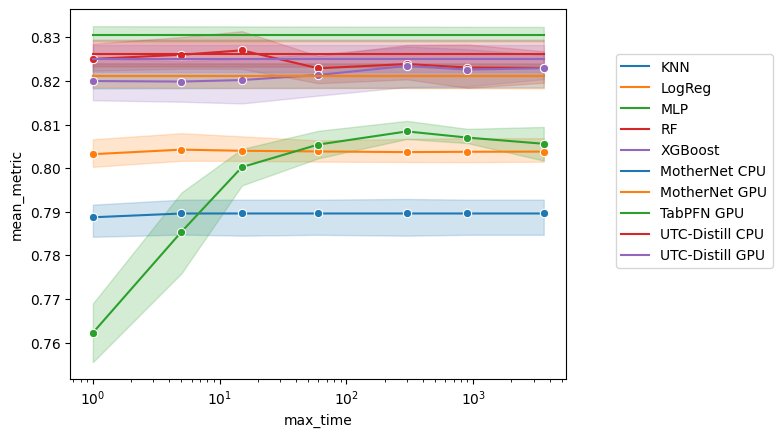

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with

In [78]:
compare_splits = results_df.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index()

import seaborn as sns
varies_over_time = ['KNN', 'XGBoost', 'RF', 'MLP', 'KNN', 'LogReg', ]
compare_splits_varies = compare_splits[compare_splits.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits[~compare_splits.model.isin(varies_over_time)]

color_palette = sns.color_palette()
# ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model", errorbar="sd", marker="o", palette=color_palette[:len(varies_over_time)])
ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o") #, palette=color_palette[:len(varies_over_time)])

compare_splits_fixed_dummy = compare_splits_fixed.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
             x="max_time", y="mean_metric", hue="model", ax=ax, ) #, palette=color_palette[len(varies_over_time):compare_splits.model.nunique()])
#sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
#             x="max_time", y="mean_metric", hue="model", errorbar="sd", ax=ax, palette=color_palette[len(varies_over_time):compare_splits.model.nunique()])
#sns.move_legend(ax, (1.01, 0))
ax.set_xscale("log")
plt.legend(loc=(1.1 , .3))
#ax.set_ylim(0.9, 0.95)

In [83]:
compare_splits_varies_last = compare_splits_varies[compare_splits_varies.max_time == compare_splits_varies.max_time.max()]

<AxesSubplot:xlabel='mean_metric', ylabel='model'>

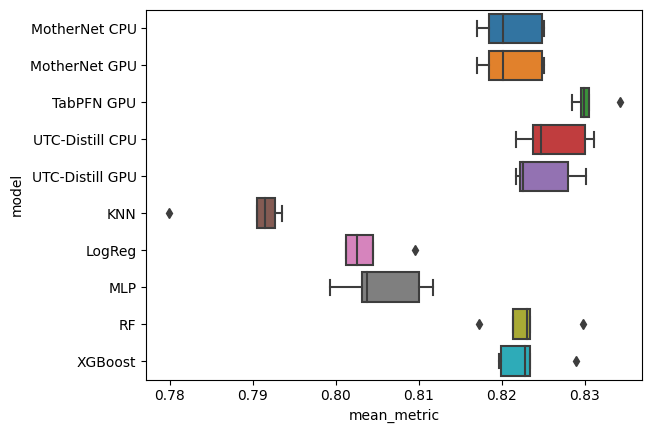

In [84]:
sns.boxplot(data=pd.concat([compare_splits_fixed, compare_splits_varies_last]), y="model", x="mean_metric")

In [85]:
average_over_splits = results_df.groupby(["dataset", "model", "max_time"])[["mean_metric", "fit_time", "inference_time"]].mean().reset_index()

In [86]:
best_tuned = average_over_splits[average_over_splits.max_time == average_over_splits.max_time.max()]
untuned = average_over_splits[~average_over_splits.model.isin(best_tuned.model.unique())]
combined_best = pd.concat([best_tuned, untuned])

In [87]:
combined_best

,dataset,model,max_time,mean_metric,fit_time,inference_time
6,CPMP-2015-runtime-classification,KNN,3600,0.700998,0.000270,0.002124
13,CPMP-2015-runtime-classification,LogReg,3600,0.712309,0.012395,0.000186
20,CPMP-2015-runtime-classification,MLP,3600,0.717512,2.732883,0.001055
29,CPMP-2015-runtime-classification,RF,3600,0.719285,0.183696,0.025886
39,CPMP-2015-runtime-classification,XGBoost,3600,0.711893,2.030625,0.025197
...,...,...,...,...,...,...
2141,wisconsin,MotherNet CPU,1,0.645392,1.463909,0.023998
2142,wisconsin,MotherNet GPU,1,0.645392,0.201164,0.060257
2150,wisconsin,TabPFN GPU,1,0.636941,0.000251,0.275171
2151,wisconsin,UTC-Distill CPU,1,0.642916,3.221482,0.001776


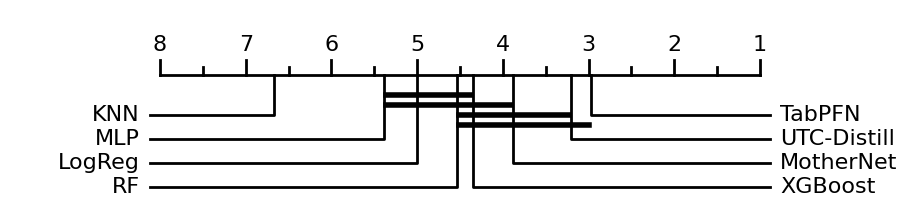

In [96]:
from tabpfn.scripts.critical_differences import draw_cd_diagram
def remove_device_from_frame(df):    
    res = df.copy()
    res = res[~res.model.str.contains("CPU")]
    res['model'] = res['model'].str.replace(" GPU", "")
    return res
res = draw_cd_diagram(remove_device_from_frame(results_without_device), dataset_column="dataset", classifier_column="model", metric_column="mean_metric");

In [89]:
results_for_ranking = results_df.pivot(index="max_time", columns=["dataset", "split", "model"], values="mean_metric").ffill()

ranks_per_split_per_dataset = results_for_ranking.stack("model").unstack("max_time").rank(ascending=False)
average_ranks = ranks_per_split_per_dataset.stack("dataset").unstack("model").mean().reset_index(name="mean_rank")

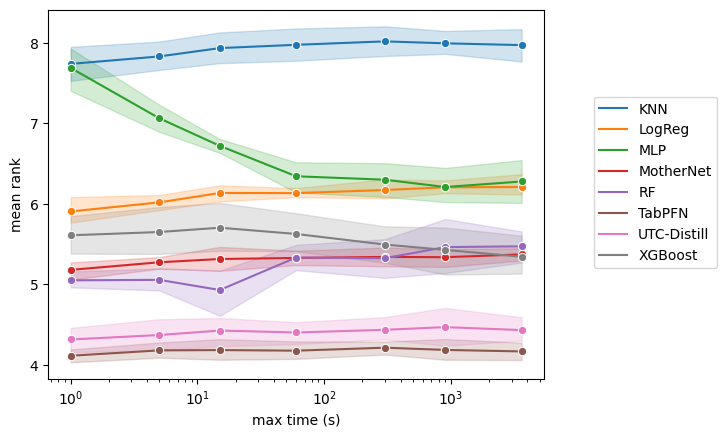

In [97]:
# ax = sns.lineplot(data=average_ranks, x="max_time", y="mean_rank", hue="model", errorbar="sd", marker="o")
ax = sns.lineplot(data=remove_device_from_frame(average_ranks), x="max_time", y="mean_rank", hue="model", marker="o")
ax.set_xscale("log")
#sns.move_legend(ax, (1.01, 0))
ax.set_ylabel("mean rank")
ax.set_xlabel("max time (s)")
plt.legend(loc=(1.1 , .3))

/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:28: Set

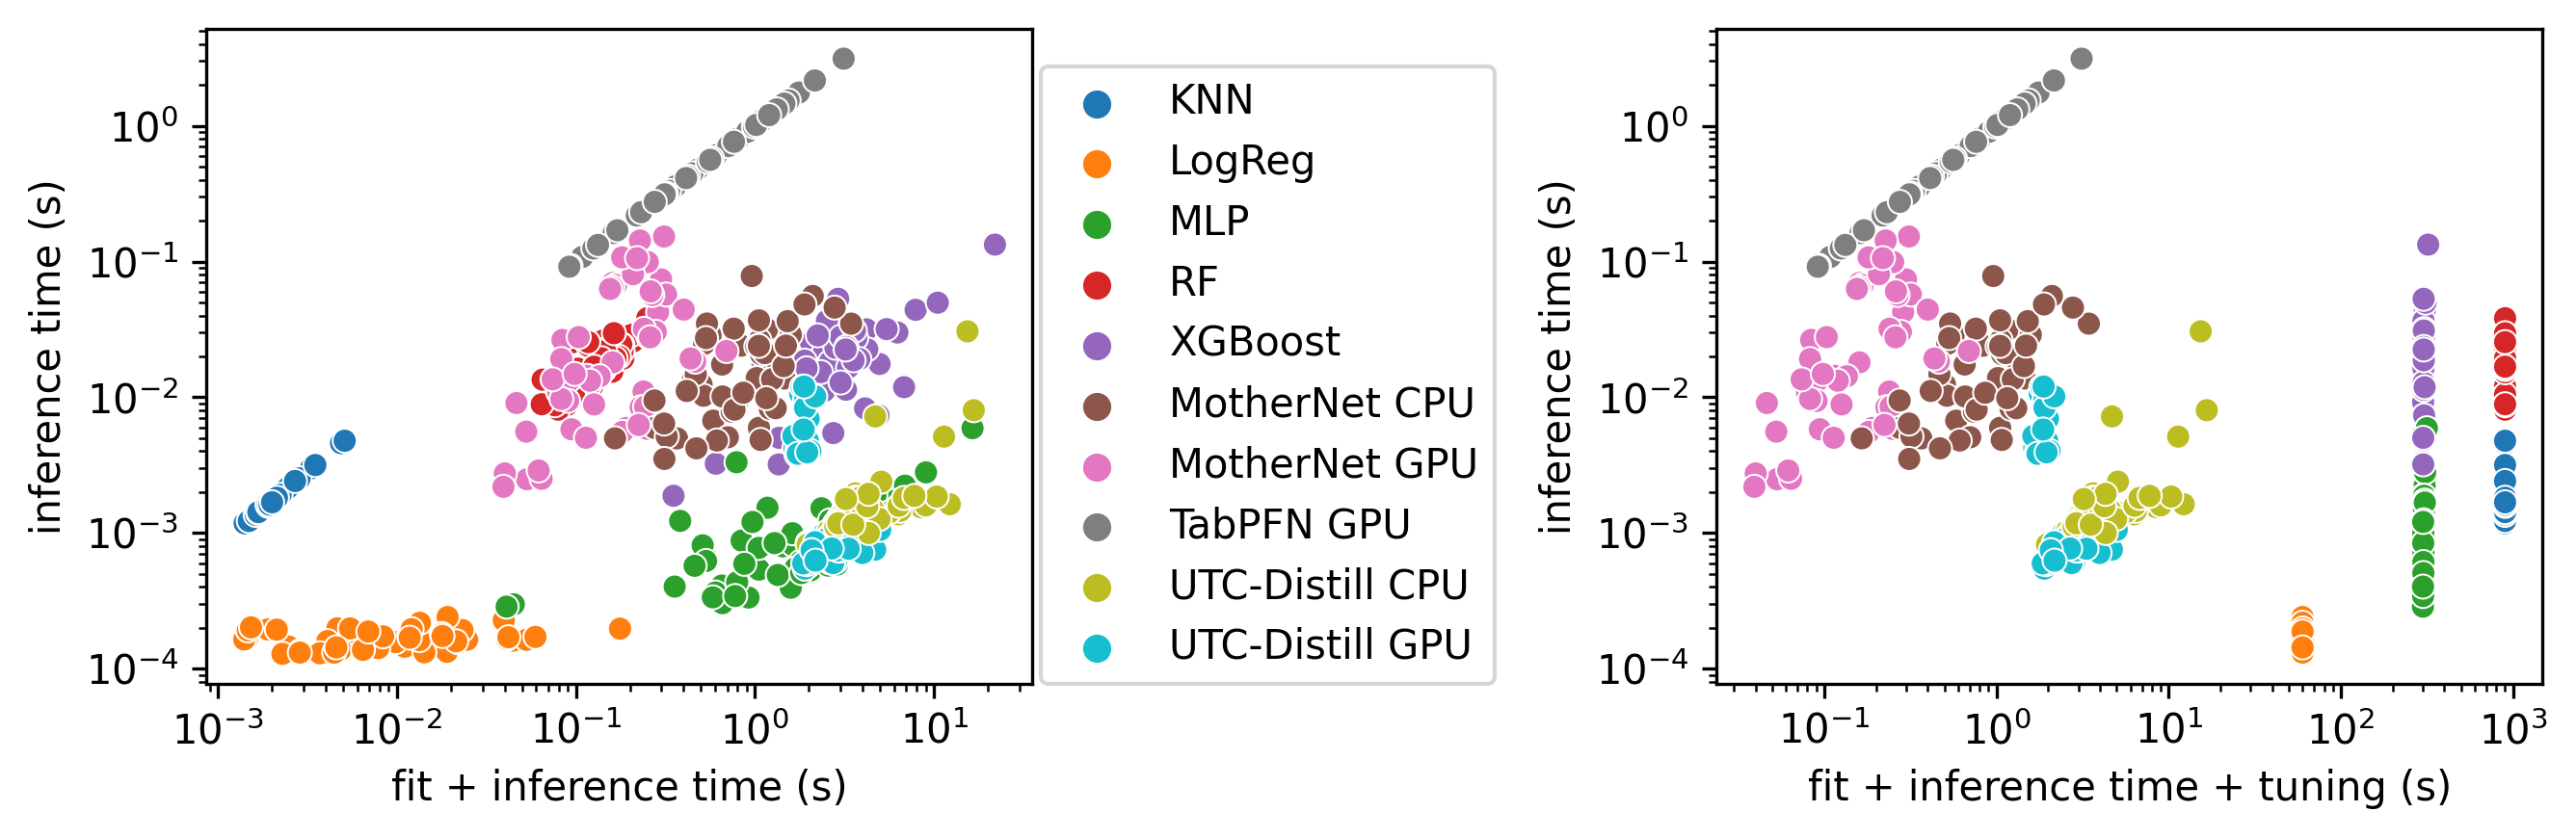

In [92]:
combined_best = pd.concat([best_tuned, untuned])
combined_best = combined_best[~combined_best.model.isin(["tabpfn_post_mlflow", "distill_tabpfn_scaled"])].copy()

fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
# sns.scatterplot(data=combined_best, y="inference_time", x="fit_time", hue="model", ax=axes[0])
# axes[0].set_xscale("log")
# axes[0].set_yscale("log")
# axes[0].set_xlabel("fit time (s)")
# axes[0].set_ylabel("inference time (s)")
# axes[0].legend().remove()

combined_best['fit_and_predict_time'] = combined_best['fit_time'] + combined_best['inference_time']

#sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU', "KNN", "LogReg", "RF", "MLP"])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("fit + inference time (s)")
axes[0].set_ylabel("inference time (s)")
legend = axes[0].legend(loc=(1.01, 0))
#sns.move_legend(axes[0], (1.01, 0))

with_tuning = combined_best.copy()
#with_tuning = with_tuning[with_tuning.model.isin(["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])]
with_tuning.fit_and_predict_time[with_tuning.model == "XGBoost"] = with_tuning.fit_and_predict_time[with_tuning.model == "XGBoost"] + 300
with_tuning.fit_and_predict_time[with_tuning.model == "MLP"] = with_tuning.fit_and_predict_time[with_tuning.model == "MLP"] + 300
with_tuning.fit_and_predict_time[with_tuning.model == "KNN"] = with_tuning.fit_and_predict_time[with_tuning.model == "KNN"] + 900
with_tuning.fit_and_predict_time[with_tuning.model == "RF"] = with_tuning.fit_and_predict_time[with_tuning.model == "RF"] + 900
with_tuning.fit_and_predict_time[with_tuning.model == "LogReg"] = with_tuning.fit_and_predict_time[with_tuning.model == "LogReg"] + 60



#sns.scatterplot(data=with_tuning, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[1], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])
sns.scatterplot(data=with_tuning, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("fit + inference time + tuning (s)")
axes[1].set_ylabel("inference time (s)")

axes[1].legend().remove()
plt.tight_layout()
plt.savefig("timing_comparison_GPU_two_panels_gpu_mlp_utc_validation.pdf")